# Telecom- predicting client departure

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

We are using the “Area Under the Curve” (AUC) of “Receiver Characteristic Operator” (ROC) metric because this is a binary classification problem (we are only intersted in answering the yes/ no question- is the user planning to leave?). The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes. <br>
In addition, we will use the metric Accuracy which is used for evaluating classification models, accuracy is the fraction of predictions our model got right. 

## Work Plan

Data Preprocessing

0. Downloading data and conducting initial data exploration
1. Converting features to desired types (boolean, dates and numerical)
2. Feature engineerings: Length of membership (from begin date until end date or last update 1/2/20)
3. Merge data to one data frame on customer id.

Exploratory Data Analysis:

5. Statistical description of data
6. Visualizing distribution of data and removing outliers
7. Analysing feature correlation (dropping irrelevant or dependent features)

Machine Learning:

8. Encoding features
9. Splitting data for training and testing
10. Training classification models : LGBM classifier, Random Forest Classifier, Logistic Regression
11. Evaluating results: Primary metric: AUC-ROC, Additional metric: Accuracy.

## Downloading & Exploring Data

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [5]:
try:
    contract = pd.read_csv('contract.csv')
    internet = pd.read_csv('internet.csv')
    personal = pd.read_csv('personal.csv')
    phone = pd.read_csv('phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [6]:
print()
print('contract:')
display(contract.sample())
contract.info()
print()
print('internet:')
display(internet.sample())
internet.info()
print()
print('personal:')
display(personal.sample())
personal.info()
print()
print('phone:')
display(phone.sample())
phone.info()


contract:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4581,9084-OAYKL,2015-04-01,No,Two year,No,Mailed check,20.8,1212.25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

internet:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3292,5446-DKWYW,DSL,No,No,Yes,No,Yes,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

personal:


,customerID,gender,SeniorCitizen,Partner,Dependents
5516,6923-EFPNL,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

phone:


,customerID,MultipleLines
2583,2454-RPBRZ,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


## EDA & Data Preprocessing 

In [7]:
# target feature is categorical
contract['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

<AxesSubplot:xlabel='EndDate', ylabel='Density'>

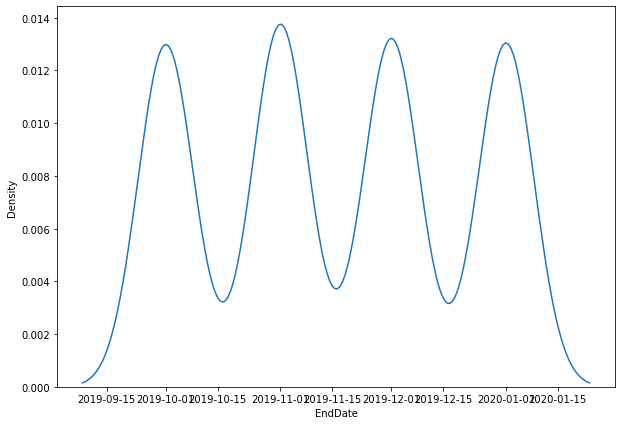

In [8]:
plt.figure(figsize=(10,7))
sns.kdeplot(contract[contract['EndDate']!='No']['EndDate'].astype('datetime64'))

The target is distributed evenly across the positive categories. 

I will convert the target to boolean values: False (client did not leave) if category is 'No' and True (client left) if category is a date.

In order to preserve the information of departure date, I will create a new feature: Membership Length in Days.

### Converting data types

In [9]:
# converting TotalCharges feature to numerical
contract.loc[contract['TotalCharges']==' ', 'TotalCharges'] = 0
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')
# converting PaperlessBilling to binary
contract['PaperlessBilling'] = contract['PaperlessBilling'].apply(lambda i: 0 if i=='No' else 1)
# creating duration feature
contract['MembershipLengthDays'] = (contract['EndDate'].apply(lambda x: x if x != 'No' else pd.to_datetime('2020-02-01')).astype('datetime64', copy=True) - pd.to_datetime(contract['BeginDate'])).dt.days
# converting target to boolean
contract['EndDate'] = contract['EndDate'].apply(lambda end: True if end != 'No' else False)
# droping BeginDate to avoid data leackage
contract.drop('BeginDate', axis=1, inplace=True)                                    
                                    
contract.sample()

C:\Users\mayah\AppData\Local\Temp\ipykernel_16316\199850077.py:7: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  contract['MembershipLengthDays'] = (contract['EndDate'].apply(lambda x: x if x != 'No' else pd.to_datetime('2020-02-01')).astype('datetime64', copy=True) - pd.to_datetime(contract['BeginDate'])).dt.days


,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MembershipLengthDays
6614,4086-WITJG,False,Two year,0,Credit card (automatic),19.7,1301.1,2163


In [10]:
# converting Yes/No features to binary
for col in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
    internet[col] = internet[col].apply(lambda i: 0 if i=='No' else 1)

internet.sample()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
645,7382-DFJTU,DSL,0,0,1,1,0,0


In [11]:
# converting Yes/No features to binary
for col in ['Partner','Dependents']:
    personal[col] = personal[col].apply(lambda i: 0 if i=='No' else 1)

personal.sample()

,customerID,gender,SeniorCitizen,Partner,Dependents
4293,2114-MGINA,Female,0,0,0


In [12]:
# converting Yes/No features to binary
phone['MultipleLines'] = phone['MultipleLines'].apply(lambda i: 0 if i=='No' else 1)

phone.sample()

,customerID,MultipleLines
719,5173-WXOQV,0


In [13]:
df = contract.merge(right=personal, how='outer', on='customerID', validate='1:1')
df = df.merge(right=internet, how='outer', on='customerID', validate='1:1')
df = df.merge(right=phone, how='outer', on='customerID', validate='1:1')

df.sample(5)

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MembershipLengthDays,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
4790,5216-WASFJ,False,Month-to-month,1,Electronic check,84.85,2633.40,945,Female,1,1,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6282,1354-YZFNB,False,Two year,0,Credit card (automatic),19.55,68.80,123,Male,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3675,9753-OYLBX,False,Month-to-month,0,Mailed check,20.50,20.50,31,Female,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6581,2453-SAFNS,False,One year,0,Mailed check,72.10,3886.05,1645,Female,1,0,0,DSL,0.0,1.0,0.0,1.0,1.0,0.0,1.0
3505,1335-NTIUC,False,Month-to-month,1,Electronic check,24.95,190.25,276,Male,0,0,0,DSL,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## EDA

In [14]:
#checking for the dimension of the data
rows, column = df.shape
print('The dataset contains', rows, 'rows and', column, 'columns.')

The dataset contains 7043 rows and 20 columns.


In [15]:
df.describe()

,PaperlessBilling,MonthlyCharges,TotalCharges,MembershipLengthDays,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,6361.000000
mean,0.592219,64.761692,2279.734304,985.996166,0.162147,0.483033,0.299588,0.365960,0.440276,0.439007,0.370491,0.490665,0.495197,0.467065
std,0.491457,30.090047,2266.794470,747.587844,0.368612,0.499748,0.458110,0.481742,0.496465,0.496311,0.482980,0.499958,0.500022,0.498953
min,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.500000,398.550000,273.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,70.350000,1394.550000,883.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,89.850000,3786.600000,1676.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,118.750000,8684.800000,2191.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
df.describe(include=['object', 'bool'])

,customerID,EndDate,Type,PaymentMethod,gender,InternetService
count,7043,7043,7043,7043,7043,5517
unique,7043,2,3,4,2,2
top,7590-VHVEG,False,Month-to-month,Electronic check,Male,Fiber optic
freq,1,5174,3875,2365,3555,3096


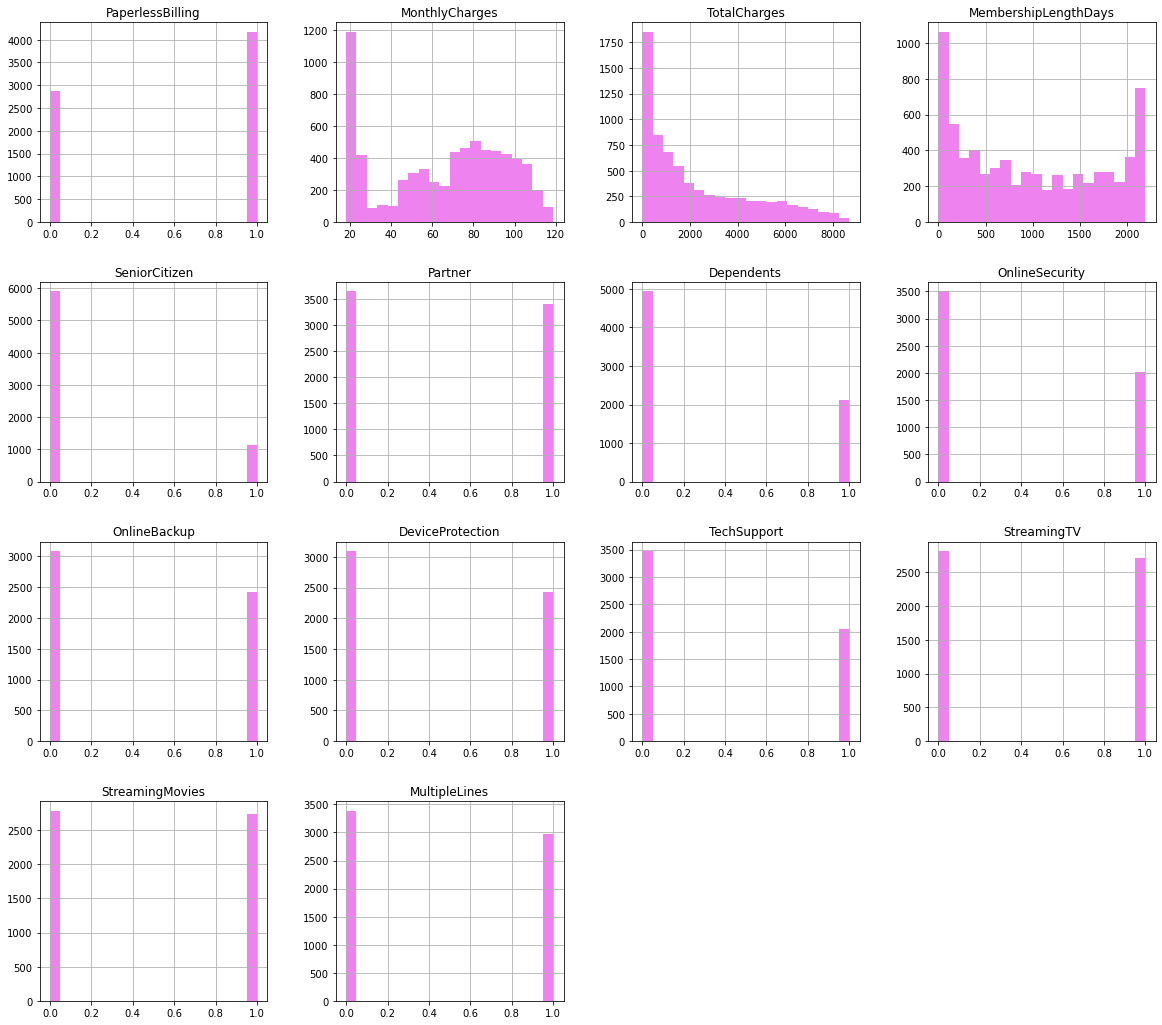

In [17]:
df.hist(bins = 20, figsize = (20, 18), color = 'violet');

C:\Users\mayah\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mayah\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mayah\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


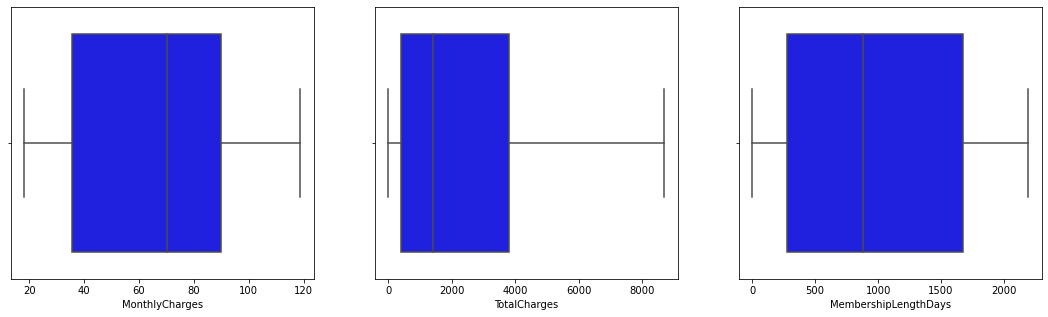

In [18]:
plt.figure(figsize=(25,23))
col = 1
for i in ['MonthlyCharges','TotalCharges','MembershipLengthDays']:
    plt.subplot(4, 4, col)
    sns.boxplot(df[i],color='blue')
    col += 1

There are no outliers in the numerical features of the data

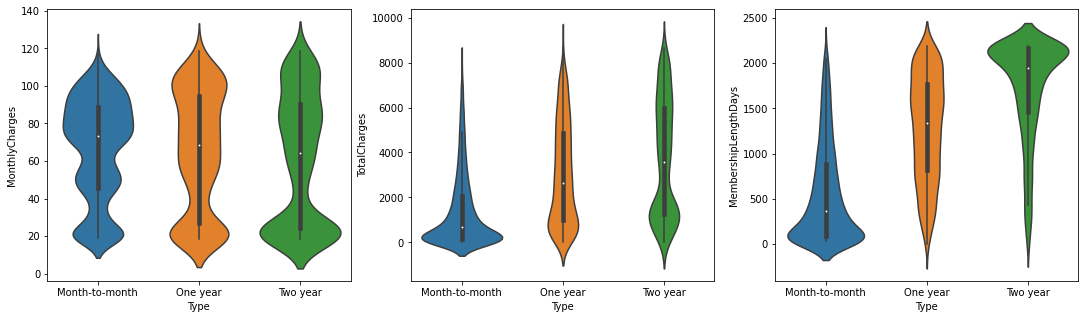

In [19]:
plt.figure(figsize=(25,23))
col = 1
for i in ['MonthlyCharges','TotalCharges','MembershipLengthDays']:
    plt.subplot(4, 4, col)
    sns.violinplot(data=df, y=i ,x='Type')
    col += 1

C:\Users\mayah\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mayah\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mayah\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mayah\anaconda3\lib\si

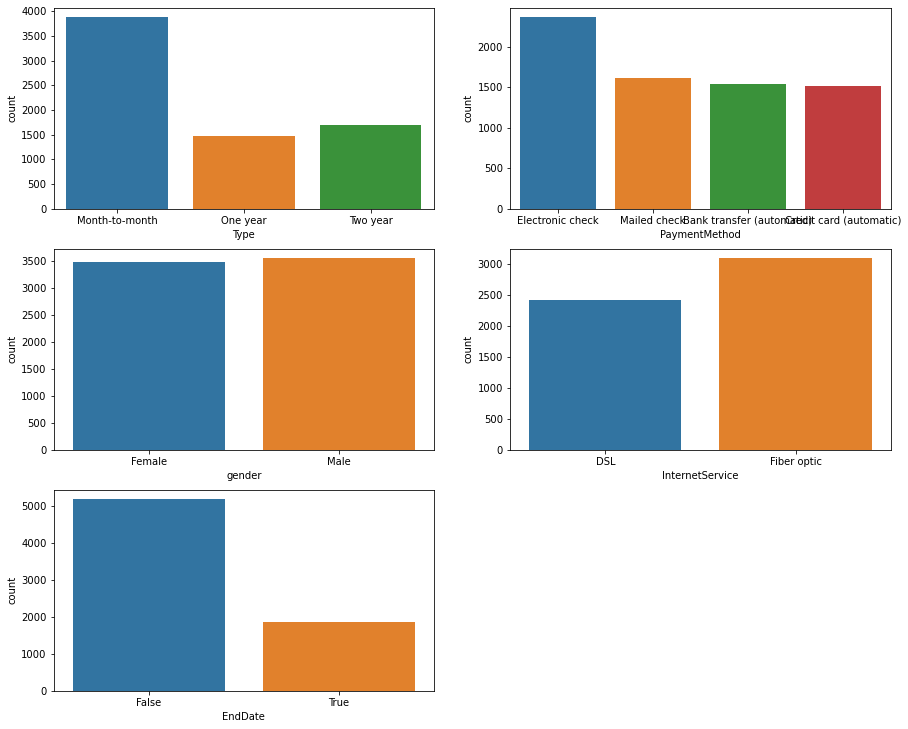

In [20]:
plt.figure(figsize=(15,17))
i = 1
for col in ['Type','PaymentMethod','gender','InternetService', 'EndDate']:
    plt.subplot(4, 2, i)
    sns.countplot(df[col], x=col)
    i += 1

### Encoding categorical features with one-hot-encoding

In [21]:
categorical_columns = ['Type','PaymentMethod','gender','InternetService', 'EndDate']
numerical_columns = ['PaperlessBilling','MonthlyCharges','TotalCharges','MembershipLengthDays','SeniorCitizen','Partner','Dependents','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','MultipleLines']
encoded_columns = pd.get_dummies(df[categorical_columns], drop_first=True)
df_ohe = encoded_columns.join(df[numerical_columns].fillna(0))
df_ohe.sample(3)

,EndDate,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,InternetService_Fiber optic,PaperlessBilling,MonthlyCharges,...,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
2253,False,0,1,0,0,0,1,0,0,74.40,...,1,1,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1783,True,0,0,0,1,0,1,1,1,71.65,...,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3343,False,1,0,0,0,0,0,0,0,20.10,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### checking target correlation with features

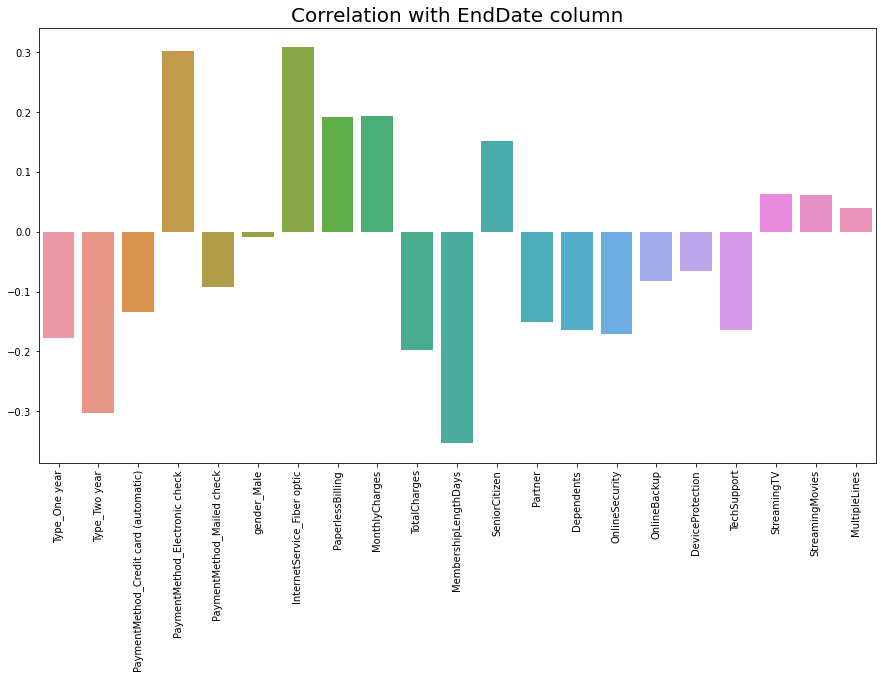

In [22]:
features = df_ohe.drop('EndDate', axis=1)
target = df_ohe['EndDate']

#plotting the correlation with target variable
plt.figure(figsize = (15, 8))
ax=sns.barplot(x=features.columns, y = features.corrwith(target))
sns.barplot(x = features.columns, y = features.corrwith(target))
plt.title('Correlation with EndDate column', fontsize = 20)
x=plt.setp(ax.get_xticklabels(), rotation=90)

In [23]:
# droping gender feature
features = features.drop(['gender_Male'], axis=1)

features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Type_One year                          7043 non-null   uint8  
 1   Type_Two year                          7043 non-null   uint8  
 2   PaymentMethod_Credit card (automatic)  7043 non-null   uint8  
 3   PaymentMethod_Electronic check         7043 non-null   uint8  
 4   PaymentMethod_Mailed check             7043 non-null   uint8  
 5   InternetService_Fiber optic            7043 non-null   uint8  
 6   PaperlessBilling                       7043 non-null   int64  
 7   MonthlyCharges                         7043 non-null   float64
 8   TotalCharges                           7043 non-null   float64
 9   MembershipLengthDays                   7043 non-null   int64  
 10  SeniorCitizen                          7043 non-null   int64  
 11  Part

### spliting data to train and test sets

In [24]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=54321)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5282, 20) (1761, 20) (5282,) (1761,)


## Machine Learning models

The metrics for determinig model quality are ROC-AUC score and Accuracy.

I will train different models and compare them to a baseline linear model.

I will find the best hyperparameters to increase model quality.


#### Baseline: Logistic Regression

In [25]:
pipe_lr = Pipeline([('res', SMOTE(sampling_strategy='minority', random_state=54321)),
                    ('sc', StandardScaler()),
                    ('clf',LogisticRegression())])
pipe_lr.fit(X_train,y_train)

cross_validate(pipe_lr, X_train, y_train, cv=5, scoring=('roc_auc', 'accuracy'), )

{'fit_time': array([0.08850026, 0.10933685, 0.0937686 , 0.10936356, 0.09367514]),
 'score_time': array([0.        , 0.        , 0.        , 0.        , 0.01568317]),
 'test_roc_auc': array([0.81616368, 0.8134058 , 0.8314166 , 0.81355838, 0.80634152]),
 'test_accuracy': array([0.74834437, 0.73982971, 0.75378788, 0.71780303, 0.75473485])}

C:\Users\mayah\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


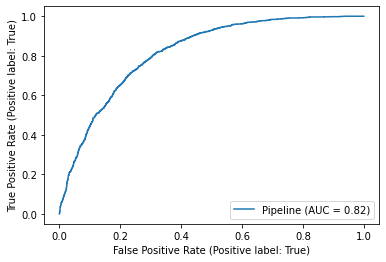

In [26]:
metrics.plot_roc_curve(pipe_lr, X_train, y_train)

#### Decision Tree Classifier

In [27]:
pipe_dt = Pipeline([('res', SMOTE(sampling_strategy='minority', random_state=54321)),
                    ('sc', StandardScaler()),
                    ('clf',DecisionTreeClassifier(class_weight='balanced'))])
pipe_dt.fit(X_train,y_train)

cross_validate(pipe_dt, X_train, y_train, cv=5, scoring=('roc_auc', 'accuracy'))

{'fit_time': array([0.09482884, 0.09329629, 0.09373689, 0.09373498, 0.09434152]),
 'score_time': array([0.        , 0.01562142, 0.        , 0.        , 0.        ]),
 'test_roc_auc': array([0.6728784 , 0.68875373, 0.68102666, 0.6811384 , 0.69675707]),
 'test_accuracy': array([0.743614  , 0.75685904, 0.73768939, 0.74526515, 0.76609848])}

C:\Users\mayah\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


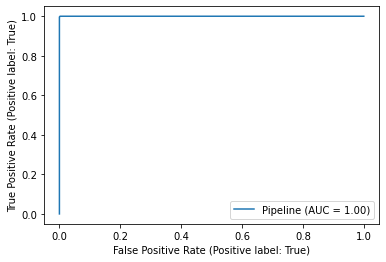

In [28]:
metrics.plot_roc_curve(pipe_dt, X_train, y_train)

#### Random Forest Classifier

In [38]:
pipe_rf = Pipeline([('res', SMOTE(sampling_strategy='minority', random_state=54321)),
                    ('sc', StandardScaler()),
                    ('clf',RandomForestClassifier(n_jobs=-1, class_weight='balanced'))])

param_grid = { 'clf__max_depth': [int(x) for x in np.linspace(10, 110, num = 5)],
               'clf__min_samples_split': [2, 5, 10],
               'clf__min_samples_leaf': [1, 2, 4],
               'clf__bootstrap': [True, False]
             }

rf = RandomizedSearchCV(pipe_rf, param_grid, n_jobs=-1)
rf.fit(X_train, y_train)

cross_validate(rf, X_train, y_train, cv=5, scoring=('roc_auc', 'accuracy'))

{'fit_time': array([2.35700607, 4.87095356, 4.97044277, 4.81066942, 4.88873529]),
 'score_time': array([0.07360578, 0.04649091, 0.06988454, 0.06380153, 0.07382083]),
 'test_roc_auc': array([0.8541781 , 0.85005985, 0.85747177, 0.82508206, 0.8406146 ]),
 'test_accuracy': array([0.81173132, 0.79943236, 0.81060606, 0.78598485, 0.80965909])}

C:\Users\mayah\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


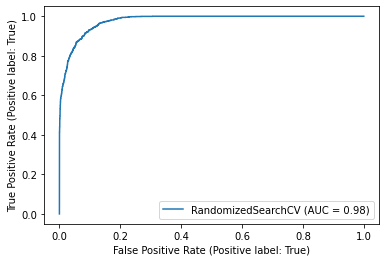

In [39]:
metrics.plot_roc_curve(rf, X_train, y_train)

#### LGBM Classifier

In [40]:
pipe_lgbm = Pipeline([('res', SMOTE(sampling_strategy='minority', random_state=54321)),
                      ('sc', StandardScaler()),
                      ('clf',LGBMClassifier(n_jobs=-1, class_weight='balanced'))])

param_grid = {'clf__n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)],
              'clf__learning_rate': [float(x) for x in np.linspace(0.01, 0.2, num = 5)],
              'clf__num_leaves': [int(x) for x in np.linspace(20, 3000, num = 5)],
              'clf__max_depth': [int(x) for x in np.linspace(start = 3, stop = 12, num = 5)],
             }

lgbm = RandomizedSearchCV(pipe_lgbm, param_grid, n_jobs=-1)
lgbm.fit(X_train, y_train)

cross_validate(lgbm, X_train, y_train, cv=5, scoring=('roc_auc', 'accuracy'))

{'fit_time': array([8.10886407, 9.83937502, 7.75673747, 7.23064351, 6.16303873]),
 'score_time': array([0.01562762, 0.01562691, 0.03124857, 0.03125095, 0.03124356]),
 'test_roc_auc': array([0.9141874 , 0.90452829, 0.9090653 , 0.90947503, 0.9222931 ]),
 'test_accuracy': array([0.87322611, 0.85335856, 0.85795455, 0.875     , 0.87973485])}

C:\Users\mayah\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


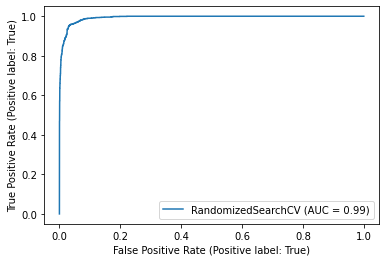

In [41]:
metrics.plot_roc_curve(lgbm, X_train, y_train)

#### XGB Classifier

In [42]:
pipe_xgb = Pipeline([('res', SMOTE(sampling_strategy='minority', random_state=54321)),
                      ('sc', StandardScaler()),
                      ('clf', XGBClassifier(n_jobs=-1))])

param_grid = {
    'clf__n_estimators': [100, 200, 500],
    'clf__learning_rate': [0.01,0.05,0.1],
    'clf__booster': ['gbtree', 'gblinear'],
    'clf__gamma': [0, 0.5, 1],
    'clf__reg_alpha': [0, 0.5, 1],
    'clf__reg_lambda': [0.5, 1, 5],
    'clf__base_score': [0.2, 0.5, 1]
}


xgb = RandomizedSearchCV(pipe_xgb, param_grid, n_jobs=-1)
xgb.fit(X_train, y_train)

cross_validate(xgb, X_train, y_train, cv=5, scoring=('roc_auc', 'accuracy'))

C:\Users\mayah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mayah\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mayah\anaconda3\lib\site-packages\imblearn\pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\mayah\anaconda3\lib\site-packages\xgboost\core.py", line 575, in inner_f
    return f(**kwargs)
  File "C:\Users\mayah\anaconda3\lib\site-pac

{'fit_time': array([5.62527966, 3.49321985, 6.04118443, 7.31155014, 6.12370634]),
 'score_time': array([0.        , 0.01562977, 0.01562166, 0.01561999, 0.01109385]),
 'test_roc_auc': array([0.88776099, 0.87748659, 0.89376324, 0.88135258, 0.89662903]),
 'test_accuracy': array([0.85241249, 0.83822138, 0.84185606, 0.83617424, 0.85132576])}

C:\Users\mayah\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


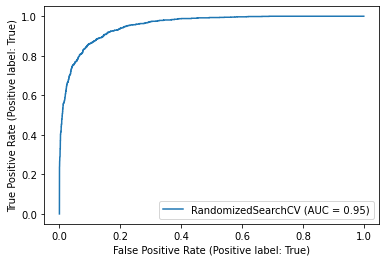

In [43]:
metrics.plot_roc_curve(xgb, X_train, y_train)

### Evaluating on Test set

In [44]:
metrics.roc_auc_score(np.array(y_test), lgbm.predict_proba(X_test)[:, 1])

0.9105465475649631

In [45]:
metrics.accuracy_score(y_test, lgbm.predict(X_test))

0.8597387847813742

C:\Users\mayah\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


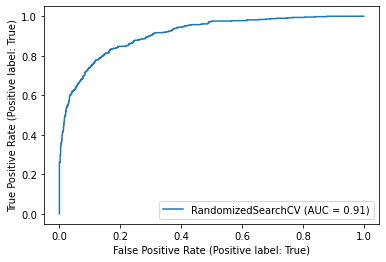

In [46]:
metrics.plot_roc_curve(lgbm, X_test, y_test)

## Conclusion

0.91 roc_auc score for LGBMCLassifier, with the following feature engeneering: creating duration feature, joining data sets and filling missing values with 0, encoding data (one hot), pipeline: resampling and scaling data. Improving quality with hyperparameter tuning. Cross validation 